In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from scipy.sparse import hstack

In [28]:
def load_data():
    train_df = pd.read_csv("train.csv")
    val_df = pd.read_csv("validation.csv")
    test_df = pd.read_csv("test.csv")
    return train_df, val_df, test_df

In [29]:
def vectorize_text(train_df, val_df, test_df):
    tfidf = TfidfVectorizer(max_features=3000)
    X_train_text = tfidf.fit_transform(train_df["transformed_text"])
    X_val_text = tfidf.transform(val_df["transformed_text"])
    X_test_text = tfidf.transform(test_df["transformed_text"])
    return tfidf, X_train_text, X_val_text, X_test_text

In [30]:
def combine_features(X_text, df):
    extra_features = df[["num_characters", "num_words", "num_sentences"]].values
    X = hstack([X_text, extra_features])
    return X

In [31]:
def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

In [32]:
def score_model(model, X, y):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    return y_pred, acc

def evaluate_model(y_true, y_pred, dataset_name=""):
    metrics = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred)
    }

    print(f"\nEvaluation on {dataset_name} Data")
    print("-" * 40)
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    return metrics

In [33]:
def plot_model_evaluation(model, X_test, y_test, model_name="Model"):
    # ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        y_prob = model.decision_function(X_test)  # SVM support

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Ham","Spam"], yticklabels=["Ham","Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


In [34]:
def tune_logistic_regression(X_train, y_train, X_val, y_val):
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING: LOGISTIC REGRESSION")
    print("="*60)

    C_values = [0.01, 0.1, 1, 10]
    best_f1 = 0
    best_model = None

    for C in C_values:
        model = LogisticRegression(
            C=C,
            max_iter=1000,
            class_weight="balanced",
            random_state=42
        )

        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        f1 = f1_score(y_val, y_val_pred)

        print(f"C={C} → Validation F1: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_model = model

    print(f"\nBest Logistic Regression F1: {best_f1:.4f}")
    return best_model


def tune_random_forest(X_train, y_train, X_val, y_val):
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING: RANDOM FOREST")
    print("="*60)

    n_estimators_list = [100, 200]
    max_depth_list = [None, 10, 20]

    best_f1 = 0
    best_model = None

    for n in n_estimators_list:
        for d in max_depth_list:
            model = RandomForestClassifier(
                n_estimators=n,
                max_depth=d,
                random_state=42,
                n_jobs=-1
            )

            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_val_pred)

            print(f"n_estimators={n}, max_depth={d} → Val F1: {f1:.4f}")

            if f1 > best_f1:
                best_f1 = f1
                best_model = model

    print(f"\nBest Random Forest F1: {best_f1:.4f}")
    return best_model



In [35]:
def train_benchmark_models(X_train, y_train, X_val, y_val, X_test, y_test):

    results = {}

    # 1. Naive Bayes    
    
    print("\n" + "#"*60)
    print("MODEL 1: MULTINOMIAL NAIVE BAYES")
    print("#"*60)

    nb_model = MultinomialNB()
    nb_model.fit(X_train, y_train)

    # Train metrics
    y_train_pred = nb_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Validation metrics
    y_val_pred = nb_model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    print(f"\nModel: Naive Bayes")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")
    print("Classification Report (Validation Set):")
    print(classification_report(y_val, y_val_pred))

    # Test evaluation
    y_test_pred = nb_model.predict(X_test)
    test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred)
}
    plot_model_evaluation(nb_model, X_test, y_test, "Naive Bayes")

    results["Naive Bayes"] = {
        "model": nb_model,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "val_f1": val_f1,
        "test_metrics": test_metrics
    }


    # 2. Logistic Regression    
    print("\n" + "#"*60)
    print("MODEL 2: LOGISTIC REGRESSION (TUNED)")
    print("#"*60)

    # Tune logistic regression
    lr_model = tune_logistic_regression(X_train, y_train, X_val, y_val)

    y_train_pred = lr_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    y_val_pred = lr_model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    print(f"\nModel: LogisticRegression")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")
    print("Classification Report (Validation Set):")
    print(classification_report(y_val, y_val_pred))

    y_test_pred = lr_model.predict(X_test)
    test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred)
}
    plot_model_evaluation(lr_model, X_test, y_test, "Logistic Regression")

    results["Logistic Regression"] = {
        "model": lr_model,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "val_f1": val_f1,
        "test_metrics": test_metrics
    }

    # 3. Random Forest    
    print("\n" + "#"*60)
    print("MODEL 3: RANDOM FOREST (TUNED)")
    print("#"*60)

    # Tune random forest
    rf_model = tune_random_forest(X_train, y_train, X_val, y_val)

    y_train_pred = rf_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    y_val_pred = rf_model.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)

    print(f"\nModel: RandomForest")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation F1-Score: {val_f1:.4f}")
    print("Classification Report (Validation Set):")
    print(classification_report(y_val, y_val_pred))

    y_test_pred = rf_model.predict(X_test)
    test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred)
}
    plot_model_evaluation(rf_model, X_test, y_test, "Random Forest")

    results["Random Forest"] = {
        "model": rf_model,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "val_f1": val_f1,
        "test_metrics": test_metrics
    }

    return results



In [36]:
def select_best_model(results):
    comparison = []
    for name, result in results.items():
        metrics = result['test_metrics']
        comparison.append({
            'Model': name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1']
        })
    df = pd.DataFrame(comparison).sort_values('F1-Score', ascending=False)
    print(df.to_string(index=False))
    best_model_name = df.iloc[0]['Model']
    best_model = results[best_model_name]['model']
    print(f"\nBest Model: {best_model_name} (F1 = {df.iloc[0]['F1-Score']:.4f})")
    return best_model_name, best_model


In [37]:
# Load data
train_df, val_df, test_df = load_data()


In [38]:
train_df.head()

,label,message,transformed_text,num_characters,num_words,num_sentences
0,0,No I don't have cancer. Moms making a big deal...,cancer mom make big deal regular checkup aka p...,85,18,1
1,0,I finished my lunch already. U wake up already?,finish lunch alreadi u wake alreadi,47,9,2
2,0,Oops. 4 got that bit.,oop 4 got bit,21,5,2
3,0,Get down in gandhipuram and walk to cross cut ...,get gandhipuram walk cross cut road right side...,109,20,2
4,0,Bull. Your plan was to go floating off to IKEA...,bull plan go float ikea without care world liv...,129,28,3



############################################################
MODEL 1: MULTINOMIAL NAIVE BAYES
############################################################

Model: Naive Bayes
Train Accuracy: 0.9485
Validation Accuracy: 0.9315
Validation F1-Score: 0.6294
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       676
           1       1.00      0.46      0.63        98

    accuracy                           0.93       774
   macro avg       0.96      0.73      0.80       774
weighted avg       0.94      0.93      0.92       774



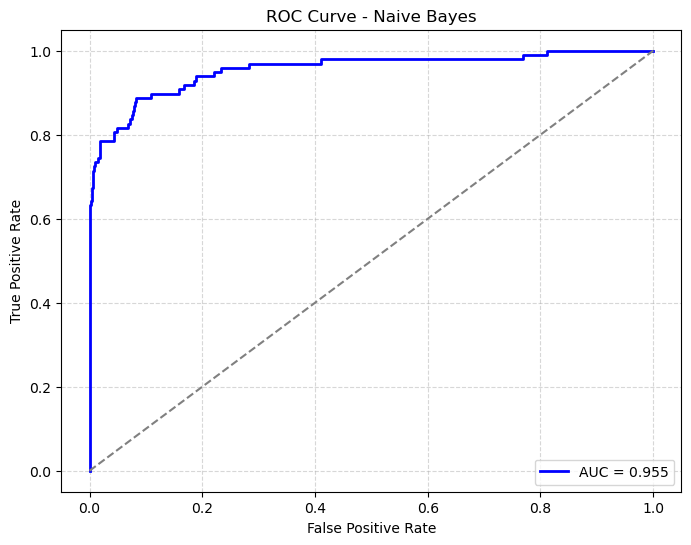

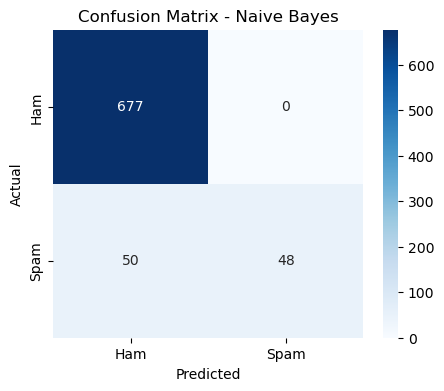


############################################################
MODEL 2: LOGISTIC REGRESSION (TUNED)
############################################################

HYPERPARAMETER TUNING: LOGISTIC REGRESSION
C=0.01 → Validation F1: 0.6097
C=0.1 → Validation F1: 0.7054
C=1 → Validation F1: 0.8558
C=10 → Validation F1: 0.9215

Best Logistic Regression F1: 0.9215

Model: LogisticRegression
Train Accuracy: 0.9956
Validation Accuracy: 0.9806
Validation F1-Score: 0.9215
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       676
           1       0.95      0.90      0.92        98

    accuracy                           0.98       774
   macro avg       0.97      0.95      0.96       774
weighted avg       0.98      0.98      0.98       774



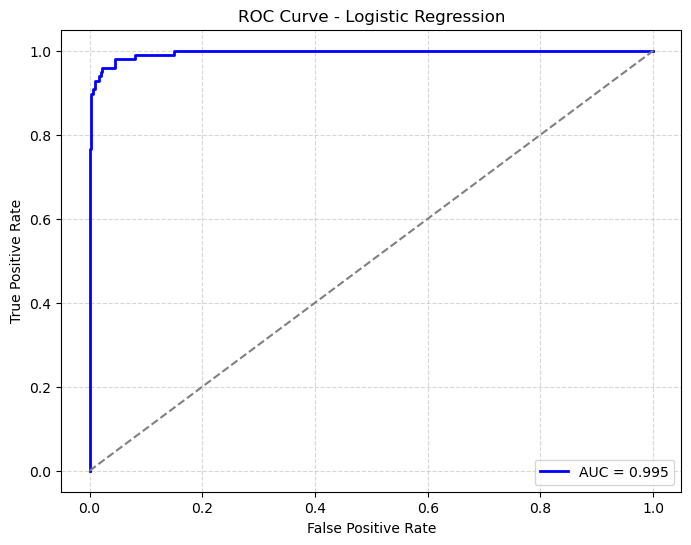

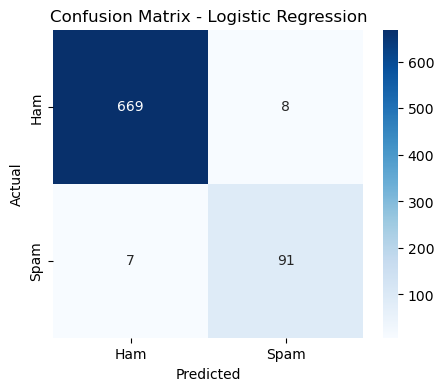


############################################################
MODEL 3: RANDOM FOREST (TUNED)
############################################################

HYPERPARAMETER TUNING: RANDOM FOREST
n_estimators=100, max_depth=None → Val F1: 0.8686
n_estimators=100, max_depth=10 → Val F1: 0.4688
n_estimators=100, max_depth=20 → Val F1: 0.7673
n_estimators=200, max_depth=None → Val F1: 0.8750
n_estimators=200, max_depth=10 → Val F1: 0.5038
n_estimators=200, max_depth=20 → Val F1: 0.7516

Best Random Forest F1: 0.8750

Model: RandomForest
Train Accuracy: 1.0000
Validation Accuracy: 0.9716
Validation F1-Score: 0.8750
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       676
           1       0.99      0.79      0.88        98

    accuracy                           0.97       774
   macro avg       0.98      0.89      0.93       774
weighted avg       0.97      0.97      0.97       774



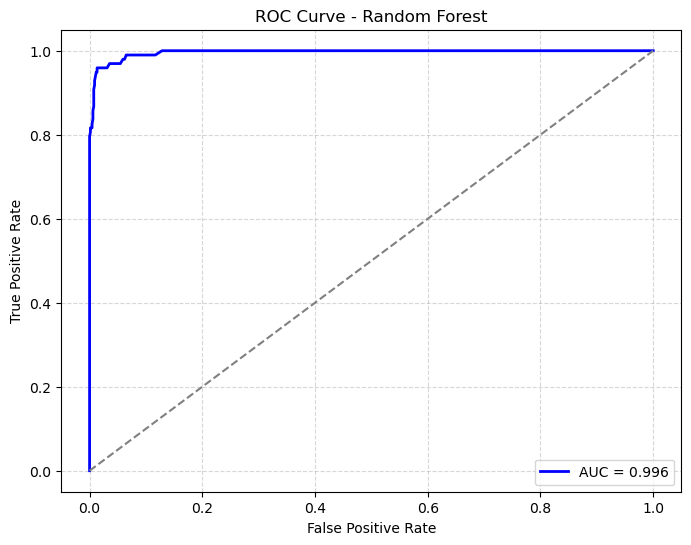

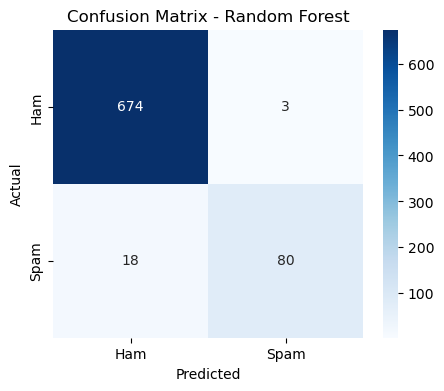

              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.980645   0.919192 0.928571  0.923858
      Random Forest  0.972903   0.963855 0.816327  0.883978
        Naive Bayes  0.935484   1.000000 0.489796  0.657534

Best Model: Logistic Regression (F1 = 0.9239)


In [39]:
# Vectorize
tfidf, X_train_text, X_val_text, X_test_text = vectorize_text(train_df, val_df, test_df)

# Combine features
X_train = combine_features(X_train_text, train_df)
X_val = combine_features(X_val_text, val_df)
X_test = combine_features(X_test_text, test_df)

y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]

# Train benchmark models with plots
results = train_benchmark_models(X_train, y_train, X_val, y_val, X_test, y_test)

# Select best model
best_model_name, best_model = select_best_model(results)
